In [1]:
pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import pytorch_lightning as pl
import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from pytorch_lightning import loggers as pl_loggers

from sklearn import decomposition
import scipy
from scipy.integrate import solve_ivp

from sklearn.feature_extraction import image
os.chdir('../')
from utils import *

In [3]:

os.chdir('DataAssimilationProject')
!pwd

/Users/charlottedurand/Documents/GitHub/DataAssimilationProject


# L96 Data simulation

In [14]:
from importlib import reload
import utils
reload(utils) 
from utils import *

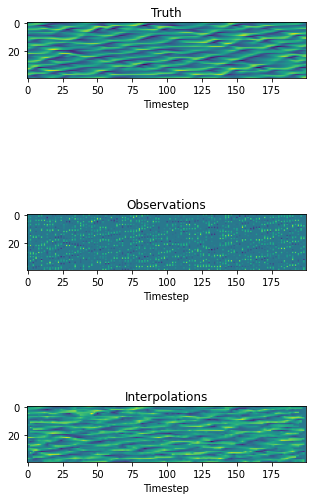

In [31]:
Training_dataset,Val_dataset,Test_dataset = L96PatchDataExtraction(sparsity=0.5,sigma_noise=np.sqrt(2),num_variables=40)


meanTe          = np.mean(Test_dataset['Missing']) / np.mean(Test_dataset['Mask']) 
stdTe           = np.sqrt( np.mean( Test_dataset['Missing']**2 ) / np.mean(Test_dataset['Mask']) )
visualisation_data96(Test_dataset['Truth'],Test_dataset['Obs'],Test_dataset['Init'],125)

# 4D Var

In [48]:


class Int(torch.nn.Module):
    def __init__(self):
        super(Int, self).__init__()
        self.F         = torch.nn.Parameter(torch.Tensor([8.]))
        self.dt        = 0.05
        self.stdTe     = stdTe
        self.meanTe    = meanTe
             
    def _odeL96(self, xin):
        
        dx  = (xin[:,3:,:]-xin[:,0:xin.size(1)-3,:]) * xin[:,1:xin.size(1)-2,:] - xin[:,2:xin.size(1)-1,:]
        dx0 = (xin[:,1,:]-xin[:,xin.size(1)-2,:]) * xin[:,xin.size(1)-1,:] - xin[:,0,:]
        dx1 = (xin[:,2,:]-xin[:,xin.size(1)-1,:]) * xin[:,0,:] - xin[:,1,:]
        dxL = (xin[:,0,:]-xin[:,xin.size(1)-3,:]) * xin[:,xin.size(1)-2,:] - xin[:,xin.size(1)-1,:]
                            
        dx0 = dx0.view(-1,1,xin.size(2))
        dx1 = dx1.view(-1,1,xin.size(2))
        dxL = dxL.view(-1,1,xin.size(2))
        
        dpred = torch.cat((dx0,dx1,dx,dxL),dim=1) + self.F
        
        return dpred

    def _EulerSolver(self, x):
        return x + self.dt * self._odeL96(x)

      
    def forward(self, x):
        xpred = self._EulerSolver( x[:,:-1,:] )
        
        xnew  = torch.cat((x[:,0,:].view(-1,1,x.size(2)),xpred),dim=1)
        return xnew
    
modelInt      = Int()
    



In [58]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelInt          = modelInt.to(device)
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init']),torch.Tensor(Test_dataset['Obs']),torch.Tensor(Test_dataset['Mask']),torch.Tensor(Test_dataset['Truth'])) # create your datset
batch_size = 128
dataloaders = {
    'dataset': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
}            
dataset_sizes = {'dataset': len(test_dataset)}

comptUpdate = 1
iterInit    = 0
iterStateUpdate = 250 
NIterGrad       = 25000
modIter         = 100
delta           = 1e4 
alpha           = 1e0* np.array([.01,0.99])

xhat_tot = []
numData  = 0
compt    = 0
for x_init,x_obs,masks,x_GT in dataloaders['dataset']:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)

    numData +=  x_GT.size(0)

    # initialisation
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIterGrad):     
        # AE projection
        x_pred = modelInt( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)

        # overall loss
        loss = alpha[0] * loss_obs + alpha[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)                                           
        # other loss types
        dB          = 0
        dT          = xhat.size(2)
        loss_R      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * masks[:,:,dB:dT-dB] )
        loss_R      = loss_R / torch.sum( masks[:,:,dB:dT-dB] )
        loss_AE_GT  = torch.mean( (modelInt(x_GT)[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 )        
        loss_I      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * (1. - masks[:,:,dB:dT-dB]) )
        loss_I      = loss_I / torch.sum( (1. - masks[:,:,dB:dT-dB]) )

        # evaluate and store losses
        if( np.mod(kk,modIter) == 0 ):  
            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            compt_kk += 1
    xhat_tot.append(xhat)
    if compt == 0 :
        loss4DVar = x_GT.size(0) * losses_test
    else :
        loss4DVar = loss4DVar + x_GT.size(0) * losses_test
    compt += 1
    

loss4DVar = stdTr**2 * loss4DVar / numData
                            


2.812584

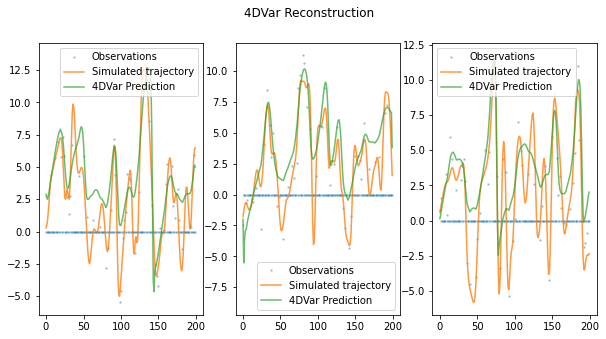

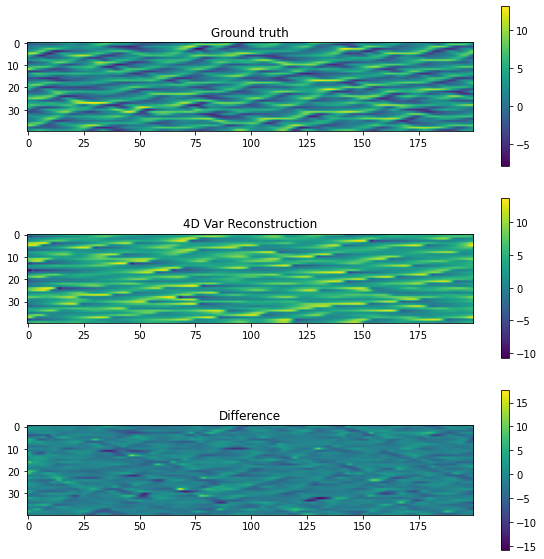

In [59]:

visualisation4DVar96(20,x_obs,x_GT,xhat)
reconstruction_error_4DVar96(x_GT,xhat)

# Baseline 2 : CNN

In [16]:
shapeData  = Training_dataset['Truth'].shape[1:]

dW = 3
dimCNN = 5
class CNN(pl.LightningModule):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1  = torch.nn.Conv1d(shapeData[1],shapeData[1]*dimCNN,2*dW+1,padding=dW,bias=False)
        self.conv2  = torch.nn.Conv1d(shapeData[1]*dimCNN,shapeData[1]*dimCNN,2*dW+1,padding=dW,bias=False)
        self.conv3  = torch.nn.Conv1d(shapeData[1]*dimCNN,shapeData[1]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv4  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv5  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv6  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,1,padding=0,bias=False)
        self.conv7  = torch.nn.Conv1d(shapeData[1]*dimCNN,shapeData[1],1,padding=0,bias=False)

        self.tot_loss=[]
        self.tot_val_loss=[]
        self.batch_size=128
        self.best_loss=1e10
        
    def forward(self,xinp):
        xinp = xinp.view(-1,shapeData[1],shapeData[0])
        
        x = self.conv1( xinp )
        
        x = self.conv2( F.relu(x) )
        
        x = self.conv3( F.relu(x) )
        
        #x = self.conv4( F.relu(x) )
        #x = self.conv5( F.relu(x) )
        #x = self.conv6( F.relu(x) )
        x = self.conv7( F.relu(x) )
        x = x.view(-1,shapeData[0],shapeData[1])
        
        return x
    def setup(self,stage='None'):
        batch_size=128
        training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(Training_dataset['Init']),torch.Tensor(Training_dataset['Obs']),torch.Tensor(Training_dataset['Mask']),torch.Tensor(Training_dataset['Truth'])) 
        val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(Val_dataset['Init']),torch.Tensor(Val_dataset['Obs']),torch.Tensor(Val_dataset['Mask']),torch.Tensor(Val_dataset['Truth']))
        test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init']),torch.Tensor(Test_dataset['Obs']),torch.Tensor(Test_dataset['Mask']),torch.Tensor(Test_dataset['Truth'])) 
        self.dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}

        
    def loss(self, x, y):
         return torch.mean((x - y)**2 )
    
    def training_step(self, train_batch, batch_idx):
        running_loss = 0.0
        num_loss     = 0
        
        inputs_init,inputs_missing,masks,targets_GT  = train_batch
        inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
        outputs     = self(inputs_init)
        loss      = torch.mean((outputs - targets_GT)**2 )
        
        running_loss             += loss.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)
        epoch_loss       = running_loss / num_loss
        self.tot_loss.append(epoch_loss)
        
        
        
        self.log('train_loss', epoch_loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs_init,inputs_missing,masks,targets_GT  = val_batch
        running_val_loss = 0.0
        num_val_loss     = 0

        outputs     = self(inputs_init)
        loss      = torch.mean((outputs - targets_GT)**2 )
           
        running_val_loss             += loss.item() * inputs_missing.size(0)
        num_val_loss                 += inputs_missing.size(0)
        epoch_val_loss       = running_val_loss / num_val_loss
        self.tot_val_loss.append(epoch_val_loss)
        

        
        self.log('val_loss', loss ,prog_bar=False,logger=False)
        if  epoch_val_loss < self.best_loss:
            self.best_loss = epoch_val_loss
            self.best_model_wts = copy.deepcopy(model_CNN.state_dict())

        return epoch_val_loss

    def configure_optimizers(self):
        self.optimizer      = optim.Adam(self.parameters(), lr=1e-4)
        self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.1)

        return self.optimizer
    
    def train_dataloader(self):
        return self.dataloaders['train']
    
    def val_dataloader(self):
        return self.dataloaders['val']
    
    def test_dataloader(self):
        return self.dataloaders['test']

In [109]:
model_CNN = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=100,enable_progress_bar=True,limit_train_batches=1.0)
trainer.fit(model_CNN)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 56.0 K
1 | conv2 | Conv1d | 280 K 
2 | conv3 | Conv1d | 280 K 
3 | conv7 | Conv1d | 8.0 K 
---------------------------------
624 K     Trainable params
0         Non-trainable params
624 K     Total params
2.496     Total estimated model params size (MB)


CNN(
  (conv1): Conv1d(40, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv2): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv3): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv7): Conv1d(200, 40, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 624000
Validation sanity check:   0%|                            | 0/2 [00:00<?, ?it/s]

/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  89%|████████████▍ | 16/18 [00:40<00:05,  2.53s/it, loss=16.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████████▍ | 16/18 [00:40<00:05,  2.51s/it, loss=13.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████████▍ | 16/18 [00:39<00:04,  2.50s/it, loss=12.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████████▍ | 16/18 [00:39<00:04,  2.50s/it, loss=11.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████████▍ | 16/18 [00:40<00:05,  2.51s/it, loss=10.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=8.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=7.82, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=7.04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  89%|████████████▍ | 16/18 [00:40<00:05,  2.50s/it, loss=6.45, v_num=0]
Validating: 0it [00:00,

Epoch 44:  89%|███████████▌ | 16/18 [00:40<00:05,  2.51s/it, loss=3.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 45:  89%|███████████▌ | 16/18 [00:40<00:05,  2.53s/it, loss=3.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 46:  89%|███████████▌ | 16/18 [00:40<00:05,  2.51s/it, loss=3.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 47:  89%|████████████▍ | 16/18 [00:40<00:05,  2.52s/it, loss=3.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 48:  89%|███████████▌ | 16/18 [00:40<00:05,  2.52s/it, loss=3.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 49:  89%|███████████▌ | 16/18 [00:40<00:05,  2.52s/it, loss=3.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 50:  89%|███████████▌ | 16/18 [00:40<00:05,  2.51s/it, loss=3.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 51:  89%|███████████▌ | 16/18 [00:40<00:05,  2.51s/it, loss=3.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 52:  89%|███████████▌ | 16/18 [00:40<00:05,  2.51s/it, loss=3.05, v_num=0]
Validating: 0it [00:00,

Epoch 88:  89%|███████████▌ | 16/18 [00:40<00:05,  2.50s/it, loss=2.86, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 89:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=2.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 90:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=2.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 91:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=2.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 92:  89%|███████████▌ | 16/18 [00:39<00:04,  2.50s/it, loss=2.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 93:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=2.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 94:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=2.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 95:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=2.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 96:  89%|███████████▌ | 16/18 [00:40<00:05,  2.52s/it, loss=2.84, v_num=0]
Validating: 0it [00:00,

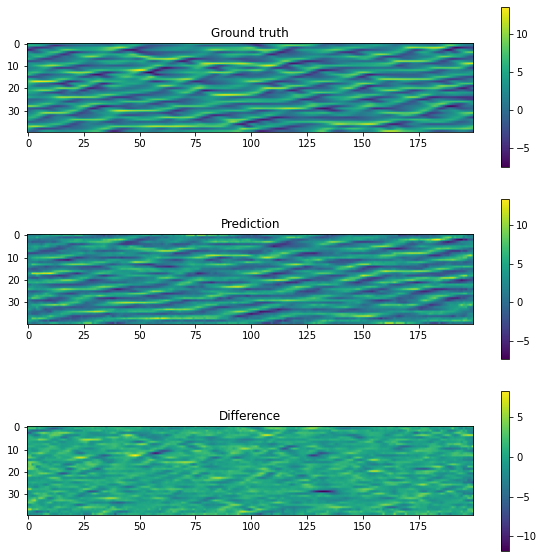

In [113]:
batch_size=128
training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(Training_dataset['Init']),torch.Tensor(Training_dataset['Obs']),torch.Tensor(Training_dataset['Mask']),torch.Tensor(Training_dataset['Truth'])) 
val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(Val_dataset['Init']),torch.Tensor(Val_dataset['Obs']),torch.Tensor(Val_dataset['Mask']),torch.Tensor(Val_dataset['Truth']))
test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init']),torch.Tensor(Test_dataset['Obs']),torch.Tensor(Test_dataset['Mask']),torch.Tensor(Test_dataset['Truth'])) 
dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}


plot_prediction96(model_CNN,25,dataloaders['test'],name='CNN96')

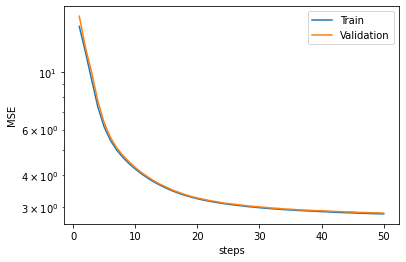

In [114]:
plot_loss(model_CNN, max_epoch=50)

In [115]:
trainer.save_checkpoint("L96CNN.ckpt")

## 35 Variables

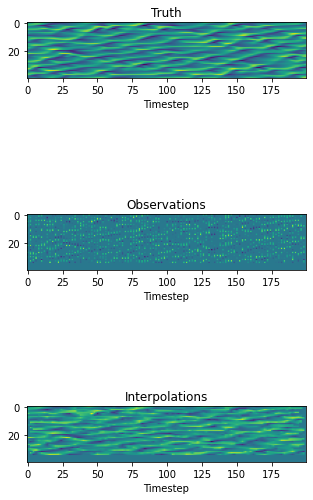

In [7]:
Training_dataset,Val_dataset,Test_dataset = L96PatchDataExtraction(sparsity=0.5,sigma_noise=np.sqrt(2),num_variables=35)


meanTe          = np.mean(Test_dataset['Missing']) / np.mean(Test_dataset['Mask']) 
stdTe           = np.sqrt( np.mean( Test_dataset['Missing']**2 ) / np.mean(Test_dataset['Mask']) )
visualisation_data96(Test_dataset['Truth'],Test_dataset['Obs'],Test_dataset['Init'],125)

In [9]:
model_CNN = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=100,enable_progress_bar=True,limit_train_batches=1.0)
trainer.fit(model_CNN)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


CNN(
  (conv1): Conv1d(40, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv2): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv3): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv7): Conv1d(200, 40, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 624000



  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 56.0 K
1 | conv2 | Conv1d | 280 K 
2 | conv3 | Conv1d | 280 K 
3 | conv7 | Conv1d | 8.0 K 
---------------------------------
624 K     Trainable params
0         Non-trainable params
624 K     Total params
2.496     Total estimated model params size (MB)


Validation sanity check:   0%|                            | 0/2 [00:00<?, ?it/s]

/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  89%|██████████████▏ | 16/18 [00:39<00:04,  2.49s/it, loss=15, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=13.3, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=12.9, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=12.3, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████████▍ | 16/18 [00:39<00:04,  2.50s/it, loss=11.2, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████████▍ | 16/18 [00:40<00:05,  2.50s/it, loss=9.85, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████████▍ | 16/18 [00:39<00:04,  2.50s/it, loss=8.85, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 7:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=8.18, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 8:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=7.69, v_num=4]
Validating: 0it [00:00,

Epoch 22:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=5.56, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 23:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=5.5, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 24:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=5.45, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 25:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=5.4, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 26:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=5.34, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 27:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=5.3, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 28:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=5.24, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 29:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=5.2, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=5.16, v_num=4]
Validating: 0it [00:00,

Epoch 44:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.71, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 45:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.68, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 46:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.65, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 47:  89%|███████████▌ | 16/18 [00:40<00:05,  2.51s/it, loss=4.63, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 48:  89%|███████████▌ | 16/18 [00:40<00:05,  2.53s/it, loss=4.61, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 49:  89%|███████████▌ | 16/18 [00:40<00:05,  2.51s/it, loss=4.59, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 50:  89%|███████████▌ | 16/18 [00:40<00:05,  2.50s/it, loss=4.58, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 51:  89%|███████████▌ | 16/18 [00:39<00:04,  2.50s/it, loss=4.56, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 52:  89%|███████████▌ | 16/18 [00:40<00:05,  2.52s/it, loss=4.54, v_num=4]
Validating: 0it [00:00,

Epoch 66:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.35, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 67:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.34, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 68:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.33, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 69:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.32, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 70:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.31, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 71:  89%|████████████▍ | 16/18 [00:40<00:05,  2.51s/it, loss=4.3, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 72:  89%|███████████▌ | 16/18 [00:40<00:05,  2.50s/it, loss=4.29, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 73:  89%|███████████▌ | 16/18 [00:40<00:05,  2.50s/it, loss=4.28, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 74:  89%|███████████▌ | 16/18 [00:40<00:05,  2.50s/it, loss=4.27, v_num=4]
Validating: 0it [00:00,

Epoch 88:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.19, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 89:  89%|███████████▌ | 16/18 [00:39<00:04,  2.50s/it, loss=4.17, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 90:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.17, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 91:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.17, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 92:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.16, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 93:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.15, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 94:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.15, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 95:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.14, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 96:  89%|███████████▌ | 16/18 [00:39<00:04,  2.49s/it, loss=4.14, v_num=4]
Validating: 0it [00:00,

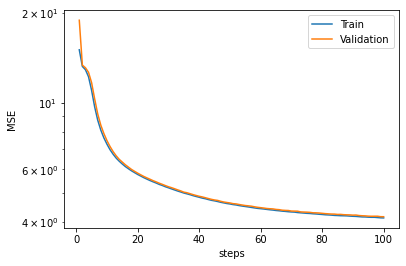

In [10]:
plot_loss(model_CNN, max_epoch=100)



Variables reconstruction score : [2.0414183 1.8962677 1.8115084 1.7930827 1.7615656 1.7773683 1.7476685
 1.7691256 1.7895617 1.7219964 1.7200772 1.749792  1.7026556 1.7275844
 1.7329632 1.7160811 1.7533762 1.7754006 1.7283897 1.7232627 1.7457129
 1.7450736 1.7703536 1.7963352 1.7502795 1.724431  1.7710571 1.7194446
 1.7516373 1.7462754 1.7184412 1.7071812 1.7858744 1.8011502 1.8661909
 3.204667  3.309194  3.264088  3.2997622 3.313334 ]
Global reconstruction score : 1.9557406902313232


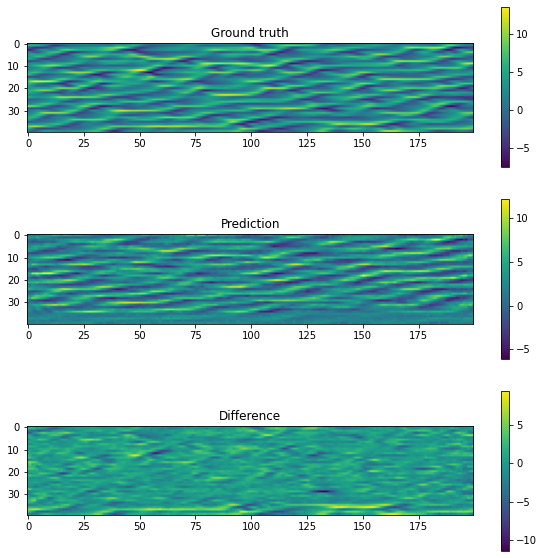

In [13]:
batch_size=128
training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(Training_dataset['Init']),torch.Tensor(Training_dataset['Obs']),torch.Tensor(Training_dataset['Mask']),torch.Tensor(Training_dataset['Truth'])) 
val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(Val_dataset['Init']),torch.Tensor(Val_dataset['Obs']),torch.Tensor(Val_dataset['Mask']),torch.Tensor(Val_dataset['Truth']))
test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init']),torch.Tensor(Test_dataset['Obs']),torch.Tensor(Test_dataset['Mask']),torch.Tensor(Test_dataset['Truth'])) 
dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}


plot_prediction96(model_CNN,25,dataloaders['test'],name='CNN96')

r_score = R_score(model_CNN,dataset = dataloaders['test'])

## 20 variables


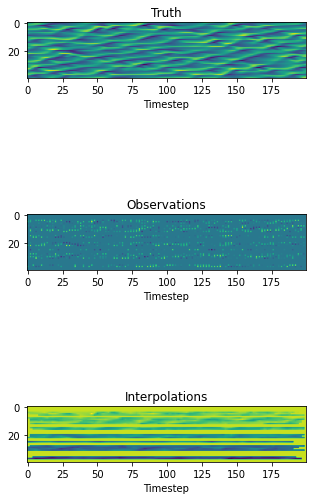

In [15]:
Training_dataset,Val_dataset,Test_dataset = L96PatchDataExtraction(sparsity=0.5,sigma_noise=np.sqrt(2),num_variables=20)


meanTe          = np.mean(Test_dataset['Missing']) / np.mean(Test_dataset['Mask']) 
stdTe           = np.sqrt( np.mean( Test_dataset['Missing']**2 ) / np.mean(Test_dataset['Mask']) )
visualisation_data96(Test_dataset['Truth'],Test_dataset['Obs'],Test_dataset['Init'],125)

In [17]:
model_CNN = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=20,enable_progress_bar=True,limit_train_batches=1.0)
trainer.fit(model_CNN)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 56.0 K
1 | conv2 | Conv1d | 280 K 
2 | conv3 | Conv1d | 280 K 
3 | conv7 | Conv1d | 8.0 K 
---------------------------------
624 K     Trainable params
0         Non-trainable params
624 K     Total params
2.496     Total estimated model params size (MB)


CNN(
  (conv1): Conv1d(40, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv2): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv3): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (conv7): Conv1d(200, 40, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 624000
Validation sanity check:   0%|                            | 0/2 [00:00<?, ?it/s]

/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  89%|████████████▍ | 16/18 [00:39<00:04,  2.48s/it, loss=14.8, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████████▍ | 16/18 [00:39<00:04,  2.50s/it, loss=13.4, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=13.3, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=13.2, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=13.1, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=12.8, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=12.5, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 7:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=11.9, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 8:  89%|████████████▍ | 16/18 [00:39<00:04,  2.49s/it, loss=11.4, v_num=5]
Validating: 0it [00:00,

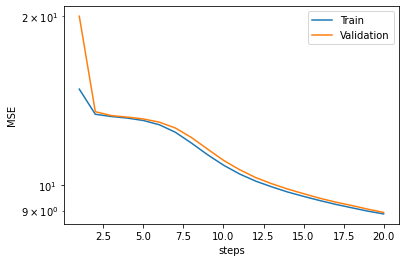

In [18]:
plot_loss(model_CNN, max_epoch=20)


Variables reconstruction score : [3.410024  3.2839265 3.1944683 3.1978536 2.905975  2.8137052 2.725298
 3.0030618 2.7271686 2.745586  2.7913942 2.7381823 2.6144986 2.982394
 2.9774415 2.6915786 2.7932765 3.0732841 2.8950746 2.9654655 2.76729
 2.784974  2.774233  3.0418103 3.0758457 2.7245452 3.0560842 2.9799745
 2.7400672 2.807686  2.7982464 2.7377706 3.096431  3.0879245 3.1155648
 3.1680403 2.9650633 2.9899805 3.255319  3.2575629]
Global reconstruction score : 2.943851947784424


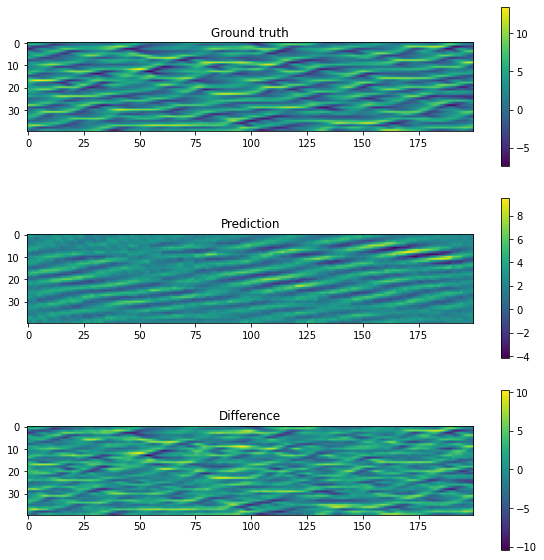

In [19]:
batch_size=128
training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(Training_dataset['Init']),torch.Tensor(Training_dataset['Obs']),torch.Tensor(Training_dataset['Mask']),torch.Tensor(Training_dataset['Truth'])) 
val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(Val_dataset['Init']),torch.Tensor(Val_dataset['Obs']),torch.Tensor(Val_dataset['Mask']),torch.Tensor(Val_dataset['Truth']))
test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init']),torch.Tensor(Test_dataset['Obs']),torch.Tensor(Test_dataset['Mask']),torch.Tensor(Test_dataset['Truth'])) 
dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}


plot_prediction96(model_CNN,25,dataloaders['test'],name='CNN96')

r_score = R_score(model_CNN,dataset = dataloaders['test'])